In [91]:
import numpy as np
import pandas as pd
import datetime
import geopandas as gpd
import ProcessSERAC
from pyproj import Transformer
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.sandbox.stats.runs import runstest_1samp 

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 5)
# rcParams['xtick.labelsize'] = 14
# rcParams['ytick.labelsize'] = 14
rcParams['axes.grid'] = True

import pickle
from Functions import *
from matplotlib.pyplot import *

In [92]:
# Datetime to decimal year
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length


# decimal year to pandas datetime
def todatetime(d):
    year = int(d)
    rem = d - year
    base = datetime.datetime(year, 1, 1)
    result = base + datetime.timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    return result


# Find the position of the k nearest elements in a 1d array to a value
def find_nearest(array, value, k):
    array = np.asarray(array)
    idx = np.argpartition(np.abs(array - value), k)
    return idx[:k]


# ADF test of the stationarity of TS
# Null: not stationary
def adf_test(timeseries):
    dftest = adfuller(timeseries)
    critical_v = list(dftest[4].values())[1] # 1, 5, 10%
    if dftest[1]<0.05 and dftest[0]<critical_v:
#     if dftest[1]<0.05:
        return [True]
    else:
        return [False, dftest[1], dftest[0], critical_v] # Not stationary, P-value, adf test statistic, critical value at the 10 % level

    
# Count the number of measurements in each year
def count_n1y(time):

    t_y = np.unique(np.array(time, dtype = int))

    n = []
    for y in t_y:
        time_y = time[np.array(time, dtype = int) == y]
        n.append(len(time_y))
        
    return pd.Series(data=n, index=t_y)


# Count the number of runs (consective negative or positive values) in auto-correlation coefficient array
def count_runs(acf_interp):
    bool_acf_interp = (acf_interp>0)*1
    v0 = bool_acf_interp[0]
    count_consec_acf = []
    n = 0
    for v in bool_acf_interp:
        if v == v0:
            n += 1
        else:
            count_consec_acf.append(n)
            n = 1
        v0 = v
    count_consec_acf.append(n)
    return np.array(count_consec_acf)

def poly_interp(time, y, deg = 3):   
    model = np.poly1d(np.polyfit(time, y, deg))

    x_pred = np.linspace(time[0], time[-1], int((time[-1]-time[0])*100))
    y_pred = model(x_pred)
    
    return x_pred, y_pred
    

# # Implement STL Decomposition
# # Doc: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html
# # n: length of the seasonal smoother, must be odd integer, normally be >= 7 (default).
# # return decomposed trend
# def deseas_STL(m):
#     m = m.set_index('time')
# #     m = m.resample('M').mean().ffill()
# #     res = sm.tsa.STL(m, seasonal = n).fit()
#     res = sm.tsa.STL(m, period = 12).fit()
#     # Comment out the following two lines to hide STL decomposition plots
#     res.plot()
#     plt.show()
#     return res.observed, res.trend, res.seasonal, res.resid



# ALPS interpolation
def ALPS_interp(Data, p = 4, q=3):
    
    #figure(figsize=(20,8))
    f1 = figure(figsize=(15,5))
    ax = subplot2grid((1,1),(0,0))
    ####### Scatter plot for the smaller time series
#     p = 3;q=2
    ax.scatter(Data[:,0],Data[:,1],color = 'r',s = 100,label = 'Data')
    [n,lamb,sigmasq] = full_search_nk(Data,p,q)
    c = n+p
    U = Kno_pspline_opt(Data,p,n)
    B = Basis_Pspline(n,p,U,Data[:,0])
    P = Penalty_p(q,c)
    theta = np.linalg.solve(B.T.dot(B) + lamb*P, B.T.dot(Data[:,1].reshape(-1,1)))
    ### Getting mean of the prediction
    num = int((Data[-1,0] - Data[0,0])*36)
    xpred_ALPS = linspace(Data[0,0],Data[-1,0],num)
    Bpred_ALPS = Basis_Pspline(n,p,U,xpred_ALPS)
    ypred1 = Bpred_ALPS.dot(theta)
    std_t1,std_n1 = Var_bounds(Data,Bpred_ALPS,B,theta,P,lamb)


    ax.plot(xpred_ALPS,ypred1,linewidth=3,color = 'g',label = 'Mean Prediction')
    ax.set_title('p = '+str(p)+ ', q = '+str(q),size = 20)
    ax.tick_params(axis='x', labelsize=19)
    ax.tick_params(axis='y', labelsize=19)
    ax.set_xlabel('Time',size=25)
    ax.set_ylabel('thickness change (m)',size = 25)
    ax.fill_between(xpred_ALPS.flatten(),ypred1.flatten()-std_t1,ypred1.flatten()+std_t1, alpha = 0.2,color = 'k',label = '95% t-interval')
    ax.legend(fontsize=20)
    ax.grid(True)
#     show()
    
    return xpred_ALPS, ypred1




def ALPS_interp_withOD(Data, p = 4, q=3, thresh1=3,thresh2 = 1.2):
    dat,out = Outlier(Data,thresh1=thresh1,thresh2 = thresh1)

    
    f1 = figure(figsize=(15,10))
    ax = subplot2grid((2,1),(0,0))

    [n,lamb,sigmasq] = full_search_nk(Data,p,q)
    c = n+p
    U = Kno_pspline_opt(Data,p,n)
    B = Basis_Pspline(n,p,U,Data[:,0])
    P = Penalty_p(q,c)
    theta = np.linalg.solve(B.T.dot(B) + lamb*P, B.T.dot(Data[:,1].reshape(-1,1)))
    ### Getting mean of the prediction
    num = int((Data[-1,0] - Data[0,0])*36)
    xpred = linspace(Data[0,0],Data[-1,0],num)
    Bpred = Basis_Pspline(n,p,U,xpred)
    ypred1 = Bpred.dot(theta)
    std_t1,std_n1 = Var_bounds(Data,Bpred,B,theta,P,lamb)


    ax.plot(xpred,ypred1,linewidth=3,color = 'r',label = 'With Full data',linestyle = '-.')
    #ax.set_title('Time Series 4',size = 25)
    ax.set_title('(a)',size = 25)
    ax.tick_params(axis='x', labelsize=19)
    ax.tick_params(axis='y', labelsize=19)
    ax.set_xlabel('Time',size=25)
    ax.set_ylabel('thickness change (m)',size = 25)
    ax.fill_between(xpred.flatten(),ypred1.flatten()-std_t1,ypred1.flatten()+std_t1, alpha = 0.2,color = 'k',label = '95% t-interval')
    ax.scatter(Data[:,0],Data[:,1],label = 'Data',color = 'b',s=100)
    ax.legend(fontsize=20,loc=3)
#     ax.set_ylim([-1.3,0.75])
    for label in ax.xaxis.get_ticklabels():
        label.set_rotation(30)
    ax.grid(True)
    
    ypred = ypred1

    ###################################

    Data = dat
    [n,lamb,sigmasq] = full_search_nk(Data,p,q)
    c = n+p
    U = Kno_pspline_opt(Data,p,n)
    B = Basis_Pspline(n,p,U,Data[:,0])
    P = Penalty_p(q,c)
    theta = np.linalg.solve(B.T.dot(B) + lamb*P, B.T.dot(Data[:,1].reshape(-1,1)))
    ### Getting mean of the prediction
#     num = 300
    xpred = linspace(Data[0,0],Data[-1,0],num)
    Bpred = Basis_Pspline(n,p,U,xpred)
    ypred2 = Bpred.dot(theta)
    std_t2,std_n2 = Var_bounds(Data,Bpred,B,theta,P,lamb)

    if len(out) != 0:
        ax = subplot2grid((2,1),(1,0))
        ax.plot(xpred,ypred1,linewidth=3,color = 'r',label = 'With Full data', linestyle = '-.',alpha = 0.5)
        ax.plot(xpred,ypred2,linewidth=3,color = 'm', label = 'Without outliers')
        ax.set_title('(b)',size = 25)
        ax.tick_params(axis='x', labelsize=19)
        ax.tick_params(axis='y', labelsize=19)
        ax.set_xlabel('Time',size=25)
        ax.set_ylabel('thickness change (m)',size = 25)
        ax.fill_between(xpred.flatten(),ypred2.flatten()-std_t2,ypred2.flatten()+std_t2, alpha = 0.2,color = 'k',label = '95% t-interval')
        ax.scatter(dat[:,0],dat[:,1],label = 'Normal Data',color = 'g',s = 100)
        ax.scatter(out[:,0],out[:,1],label = 'outlier detected',color = 'r',s = 150, marker = 'X')
        ax.legend(fontsize=20)
        for label in ax.xaxis.get_ticklabels():
            label.set_rotation(30)
    #     ax.set_ylim([-1.3,0.75])
        #subplots_adjust(left=0.19, bottom = 0, right = 0.94, top = 0.79,wspace = 0.3,hspace = 0.3)   # determines the padding on the graph
        ax.grid(True)
        subplots_adjust(left=0.09, bottom = 0, right = 0.94, top = 0.99,wspace = 0.3,hspace = 0.3)   # determines the padding on the graph
        show()
        
        ypred = ypred2
    
    return xpred, ypred


In [93]:
SERAC_dir = "/Users/huigao/Desktop/Mass_reconstruction/Annual_thickness_reconstruction/Partition_SERAC2022/"
tile_id = 6

FDM_source = "GSFC"
SERAC_GSFC = ProcessSERAC.Read(SERAC_dir+"TimeSeriesTile"+str(tile_id)+"_partitioned_"+FDM_source+".txt", 
                          max_col_count = 14, header_col_count = 13, rename_IC = True)
header_GSFC, SERAC_dic_GSFC = SERAC_GSFC.return_raw()


## better way than using FDM_source?
FDM_source = "IMAU"
SERAC_IMAU = ProcessSERAC.Read(SERAC_dir+"TimeSeriesTile"+str(tile_id)+"_partitioned_"+FDM_source+".txt", 
                          max_col_count = 14, header_col_count = 13, rename_IC = True)
header_IMAU, SERAC_dic_IMAU = SERAC_IMAU.return_raw()

# header_IMAU

In [94]:

def temp_interp(SERAC_dic, header, ts_index, FDM_source):
    colors = {'AED':'r', 'ATM':'orange', 'LVI':'cornflowerblue', 'ICESat':'k', 'IC2':'g'}

    for k in ts_index:
        id_SERAC = header.iloc[k, 0]
        print(k, id_SERAC)


        serac = SERAC_dic[id_SERAC]
        serac = serac[serac[11] != -999.]
        serac_k = serac[serac[13]==1].reset_index(drop = True)
        serac_o = serac[serac[13]>1].reset_index(drop = True)

        time = serac_k[1].values.astype(float)
        dyn = serac_k[11].values.astype(float)
        err_dyn = serac_k[12].values.astype(float)

        fig = plt.figure(figsize = (15,10))

        ax1 = fig.add_subplot(2, 1, 1)
        for key, group in pd.DataFrame({'x':time, 'y':dyn, 'sensor':serac_k[0].values}).groupby('sensor'):
            group.plot(ax=ax1, kind='scatter', x='x', y='y', label=key, color=colors[key], s = 30)
        plt.errorbar(time, dyn, yerr = err_dyn, color='grey', linestyle='')


        ax2 = fig.add_subplot(2, 1, 2)
        for d in [3]:
            x_pred, y_pred = poly_interp(time, dyn, deg = d)
            d_ts = pd.Series(data=y_pred, index=np.round(x_pred, 2))
            d_ts_dyn = d_ts.reindex(np.round(time, 2), method = 'nearest')
            d_interp_err = pd.DataFrame({'time': time, 'err': dyn - d_ts_dyn.values})
            ax1.plot(x_pred, y_pred, linewidth = 2, label = "Deg "+str(d)+" polynomial")
            ax2.scatter(d_interp_err['time'], d_interp_err['err'])

            print("Degree "+str(d)+" polynomial runs test: ", runstest_1samp(d_interp_err['err']))
            print("RMSE: ", np.round(np.sqrt(np.mean(d_interp_err['err'].values**2)), 2))

        ax1.set_xticks(np.arange(int(x_pred[0]), int(x_pred[-1]+2), 1))
        ax1.tick_params(axis='x', rotation=45)
        ax1.legend(fontsize = 14)
        ax1.set(xlabel=None, ylabel=None)
        ax1.set_title(FDM_source + " " + header[0][k] + " absh: " + str(header[5][k]), fontsize = 22)

        ax2.set_xticks(np.arange(int(x_pred[0]), int(x_pred[-1]+2), 1))
        ax2.tick_params(axis='x', rotation=45)
        ax2.set(xlabel=None, ylabel=None)


        Data = np.array([time, dyn]).T

        xpred_ALPS, ypred_ALPS = ALPS_interp_withOD(Data, p = 4, q = 3)
        d_ALPS_ts = pd.Series(data=ypred_ALPS.flatten(), index=np.round(xpred_ALPS, 2))
        d_ALPS_ts = d_ALPS_ts.reindex(np.round(time, 2), method = 'nearest')
        resid_ALPS = dyn - d_ALPS_ts

        print("ALPS runs test: ", runstest_1samp(resid_ALPS))
        print("RMSE: ", np.round(np.sqrt(np.mean(resid_ALPS**2)), 2))

        fig3, ax3 = plt.subplots(figsize = (15,5))
        ax3.scatter(np.round(time, 2), resid_ALPS, color = 'b', label = "residuals of ALPS")
        ax3.set_xticks(np.arange(int(xpred_ALPS[0]), int(xpred_ALPS[-1]+2), 1))
        ax3.tick_params(axis='x', rotation=45)
        ax3.set(xlabel=None, ylabel=None)




In [109]:
# ts_index = ts_float_ind[:10]
# ts_index = [478]
# ts_index = [332, 603, 759, 841, 1273, 1379]
ts_index = np.sort(np.random.permutation(len(header))[:10])
# ts_index = range(10, 15)

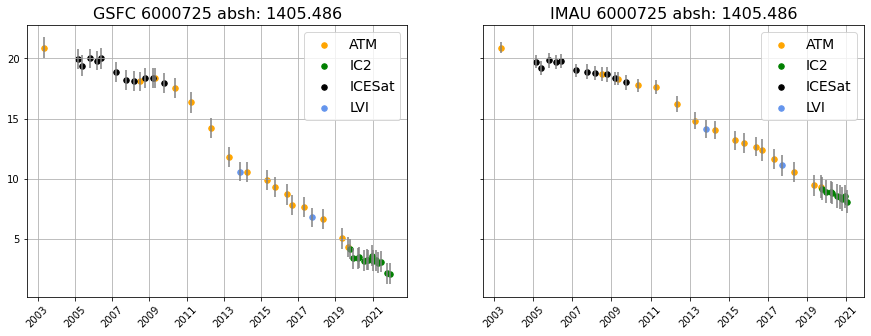

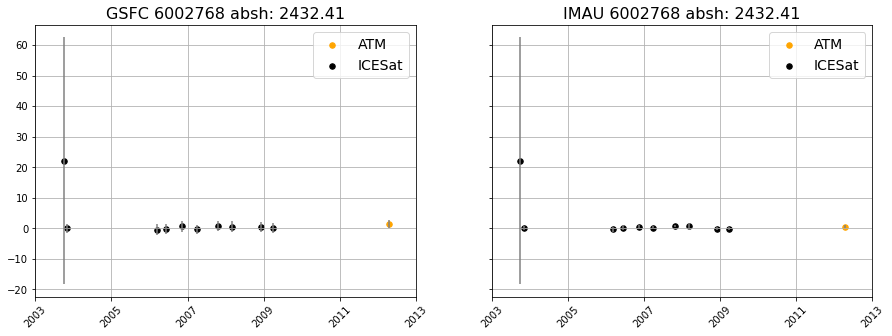

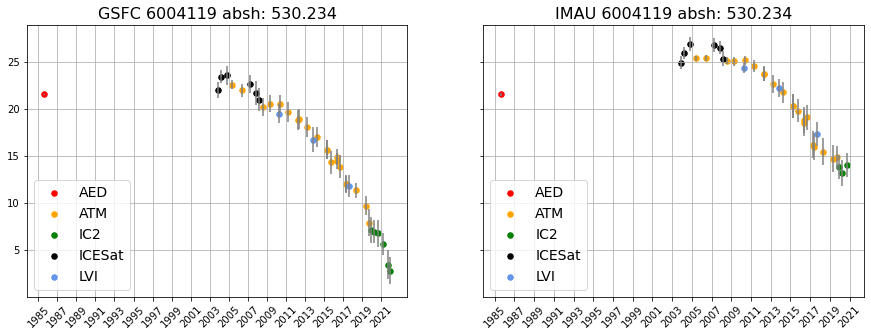

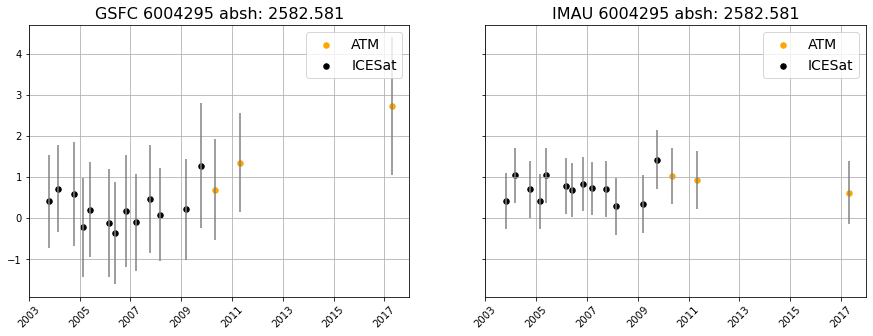

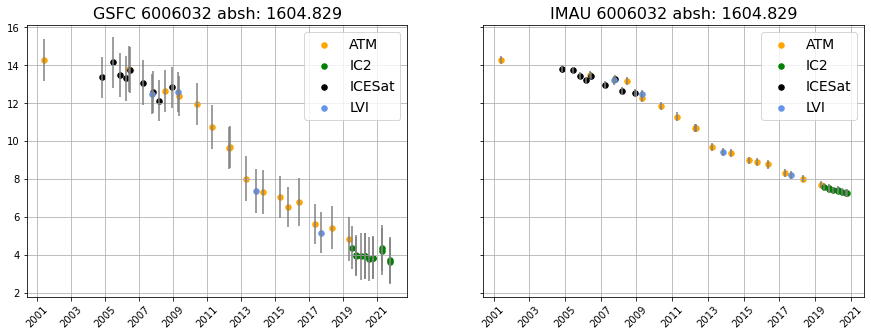

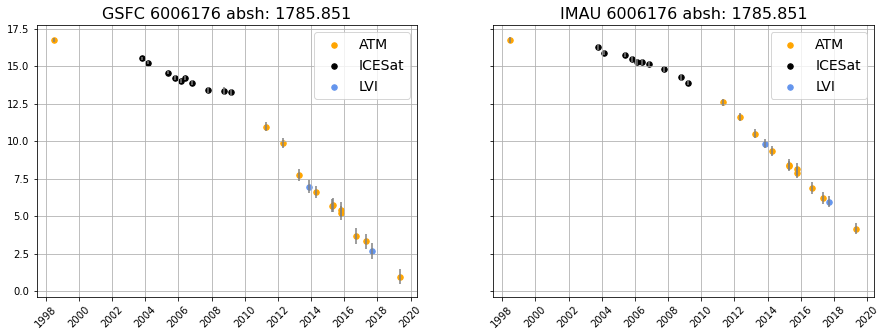

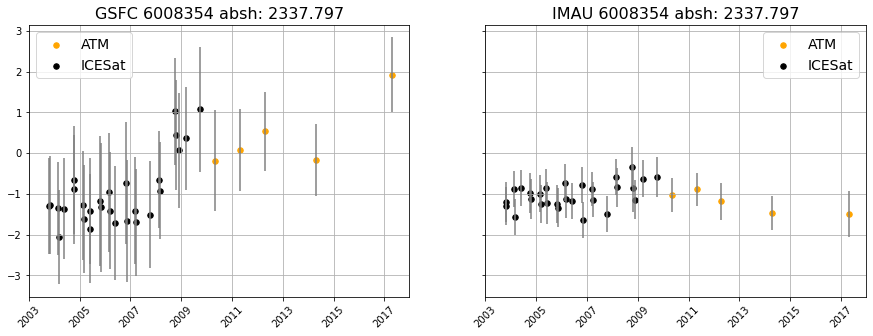

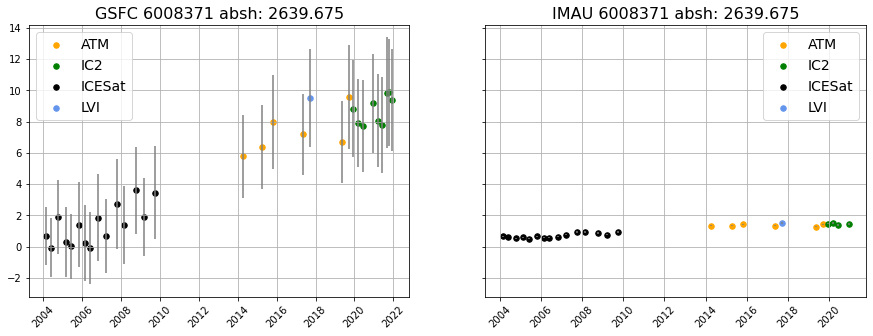

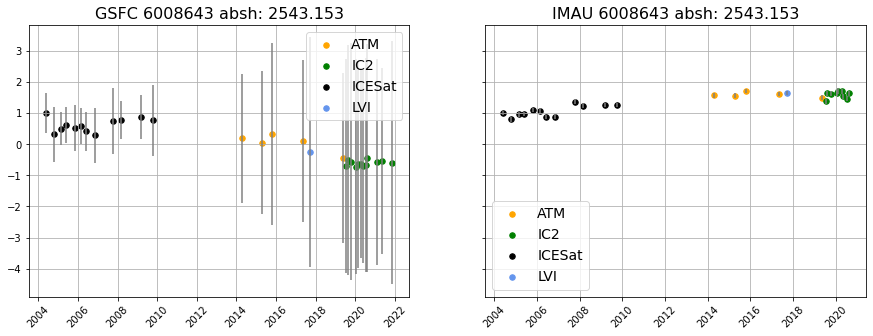

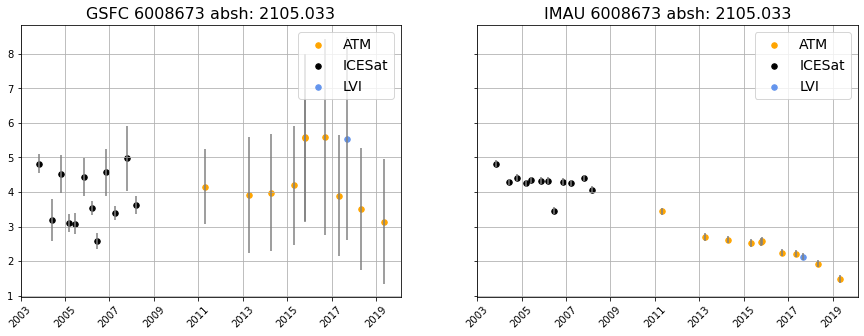

In [110]:

colors = {'AED':'r', 'ATM':'orange', 'LVI':'cornflowerblue', 'ICESat':'k', 'IC2':'g'}

SERAC_dic_l = [SERAC_dic_GSFC, SERAC_dic_IMAU]
header_l = [header_GSFC, header_IMAU]
FDM_source_l = ["GSFC", "IMAU"]

for k in ts_index:
    
    fig, ax = plt.subplots(1, 2, figsize = (15,5), sharey = True)
    for i in range(2):
        header = header_l[i]
        SERAC_dic = SERAC_dic_l[i]
        FDM_source = FDM_source_l[i]
        
        id_SERAC = header.iloc[k, 0]

        serac = SERAC_dic[id_SERAC]
        serac = serac[serac[11] != -999.]
        serac_k = serac[serac[13]==1].reset_index(drop = True)
        serac_o = serac[serac[13]>1].reset_index(drop = True)

        time = serac_k[1].values.astype(float)
        dyn = serac_k[11].values.astype(float)
        err_dyn = serac_k[12].values.astype(float)

        for key, group in pd.DataFrame({'x':time, 'y':dyn, 'sensor':serac_k[0].values}).groupby('sensor'):
            group.plot(ax=ax[i], kind='scatter', x='x', y='y', label=key, color=colors[key], s = 30)
        ax[i].errorbar(time, dyn, yerr = err_dyn, color='grey', linestyle='')

        ax[i].set_xticks(np.arange(int(time[0]), int(time[-1]+2), 2))
        ax[i].tick_params(axis='x', rotation=45)
        ax[i].legend(fontsize = 14)
        ax[i].set(xlabel=None, ylabel=None)
        ax[i].set_title(FDM_source + " " + header[0][k] + " absh: " + str(header[5][k]), fontsize = 16)



248 6000725
Degree 3 polynomial runs test:  (-3.085061837654557, 0.002035098363922398)
RMSE:  0.54


/Users/huigao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


ALPS runs test:  (2.7833794227966027, 0.0053795854145970426)
RMSE:  0.15
949 6002768
Degree 3 polynomial runs test:  (-0.6123724356957942, 0.54029137460742)
RMSE:  4.61
ALPS runs test:  (0.02916059217599047, 0.9767365107453935)
RMSE:  4.78
1448 6004119
Degree 3 polynomial runs test:  (-1.3303413174162715, 0.18340583975593028)
RMSE:  0.53


/Users/huigao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


ALPS runs test:  (-1.9735610658345923, 0.04843167450698246)
RMSE:  0.52
1491 6004295
Degree 3 polynomial runs test:  (1.381698559415515, 0.16706427691489412)
RMSE:  0.27


/Users/huigao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


ALPS runs test:  (1.90805991538333, 0.056383472784715935)
RMSE:  0.27
1991 6006032
Degree 3 polynomial runs test:  (-1.7075131827472971, 0.08772670965937646)
RMSE:  0.41


/Users/huigao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


ALPS runs test:  (2.740737318918285, 0.006130149445080326)
RMSE:  0.11
2026 6006176
Degree 3 polynomial runs test:  (-1.2281698107390688, 0.21938322896025408)
RMSE:  0.43


/Users/huigao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


ALPS runs test:  (1.6479830746356938, 0.09935614441004814)
RMSE:  0.14
2528 6008354
Degree 3 polynomial runs test:  (-1.4108824849857293, 0.15827926746586052)
RMSE:  0.59


/Users/huigao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


ALPS runs test:  (1.1189597874441959, 0.26315729472499494)
RMSE:  0.32
2535 6008371
Degree 3 polynomial runs test:  (2.200369793278278, 0.02778066916503538)
RMSE:  0.88


/var/folders/56/xnvr8b9d32b6yxqj4l67jq6r0000gn/T/ipykernel_7218/3862170355.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig3, ax3 = plt.subplots(figsize = (15,5))
/Users/huigao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


ALPS runs test:  (2.200369793278278, 0.02778066916503538)
RMSE:  0.85
2625 6008643
Degree 3 polynomial runs test:  (-2.287269639689088, 0.022180089433960395)
RMSE:  0.18


/Users/huigao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


ALPS runs test:  (1.804576484340723, 0.07114098063793364)
RMSE:  0.08
2630 6008673
Degree 3 polynomial runs test:  (0.6931411489645406, 0.4882209763815323)
RMSE:  0.74


/Users/huigao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


ALPS runs test:  (0.6931411489645406, 0.4882209763815323)
RMSE:  0.69


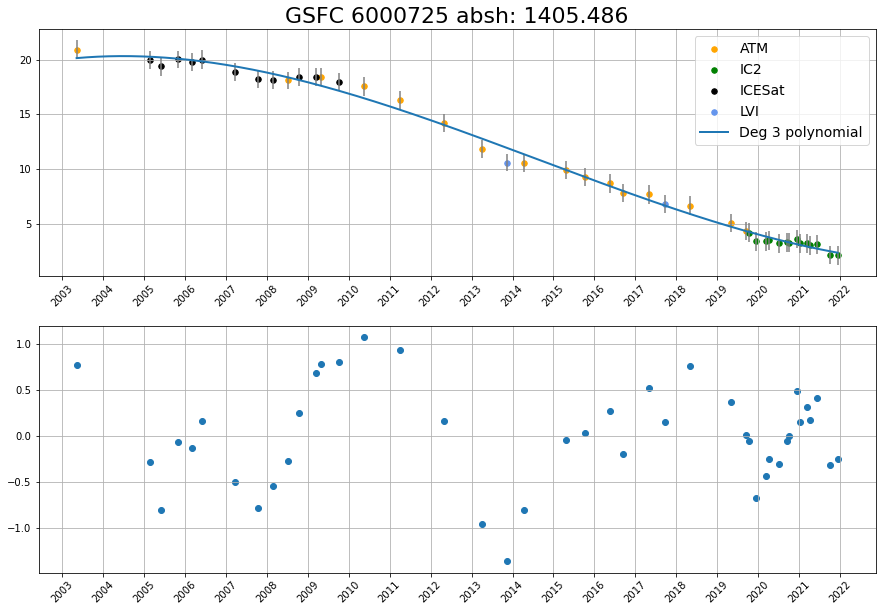

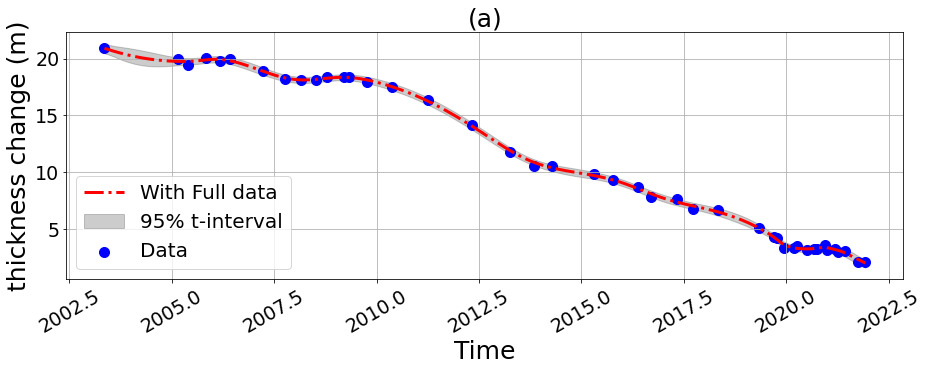

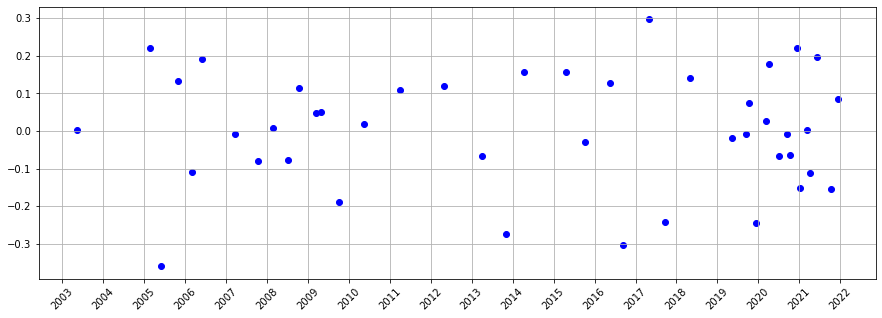

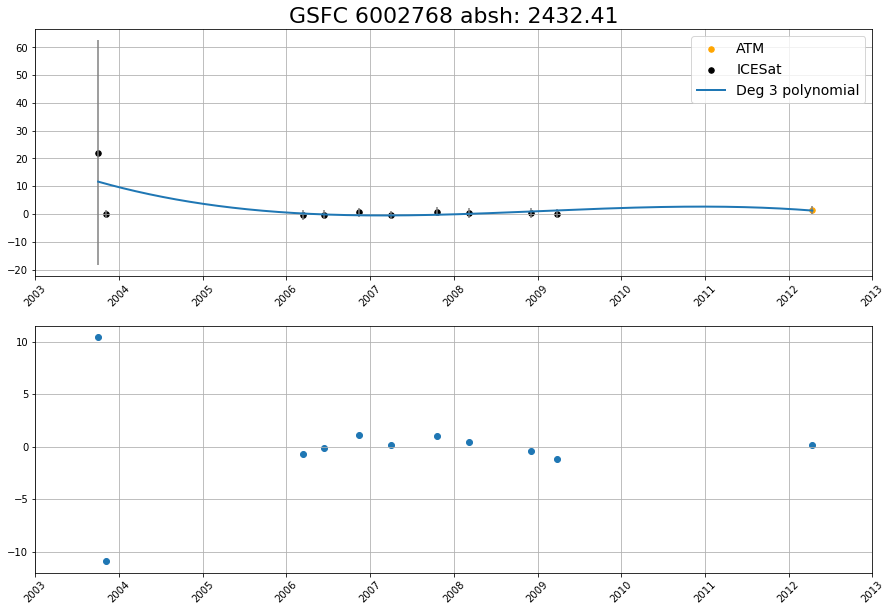

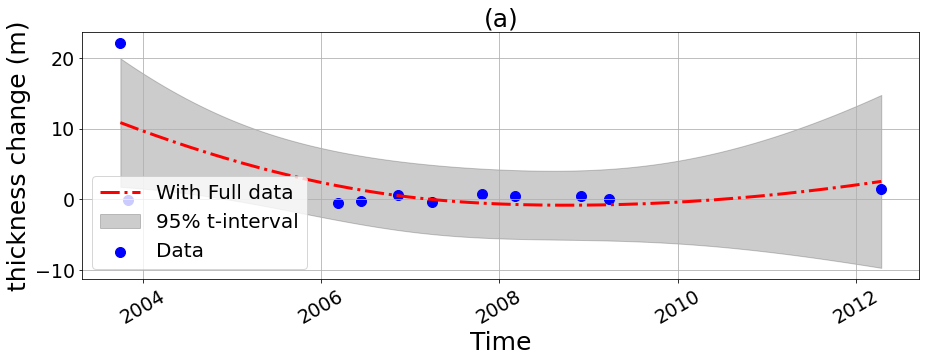

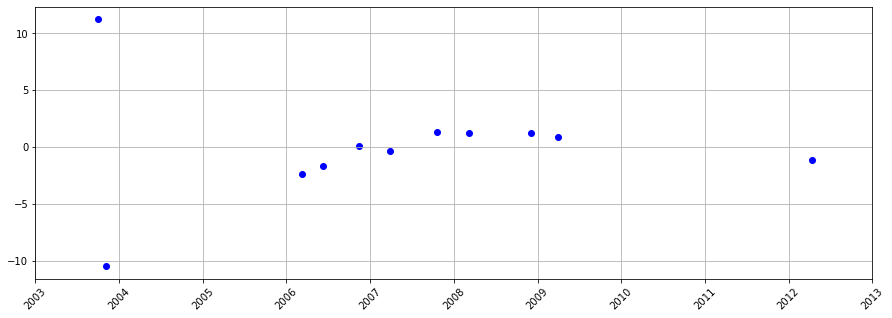

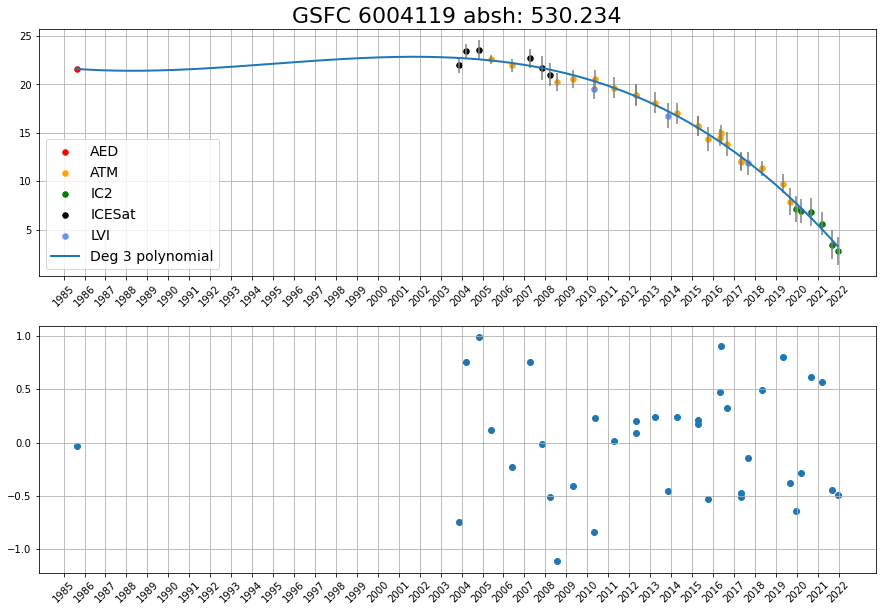

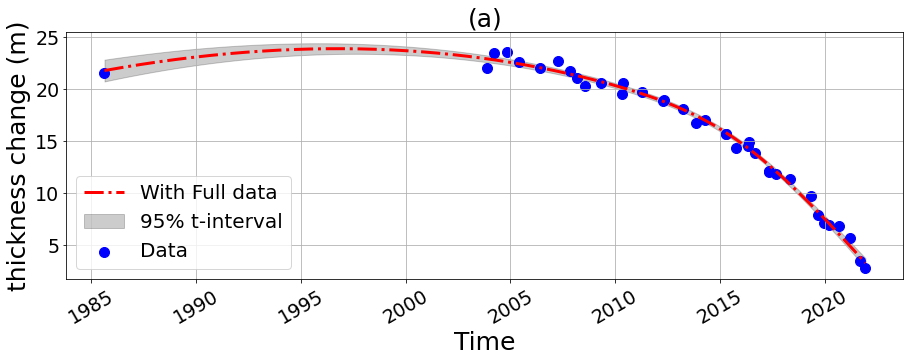

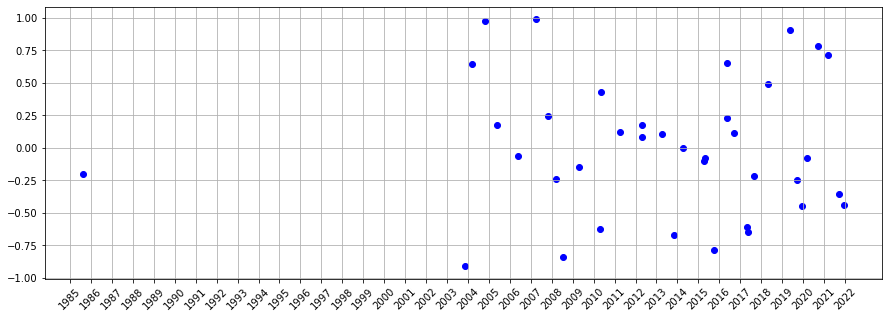

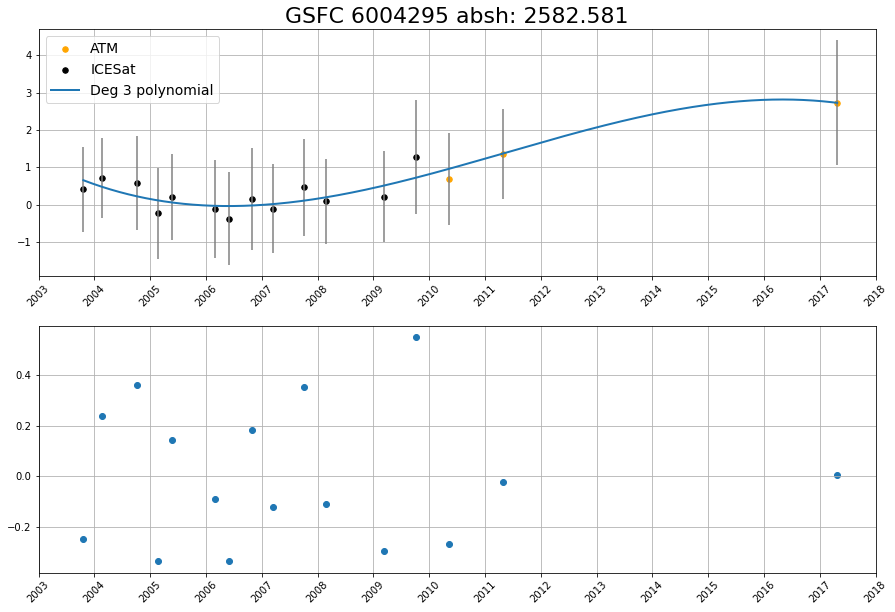

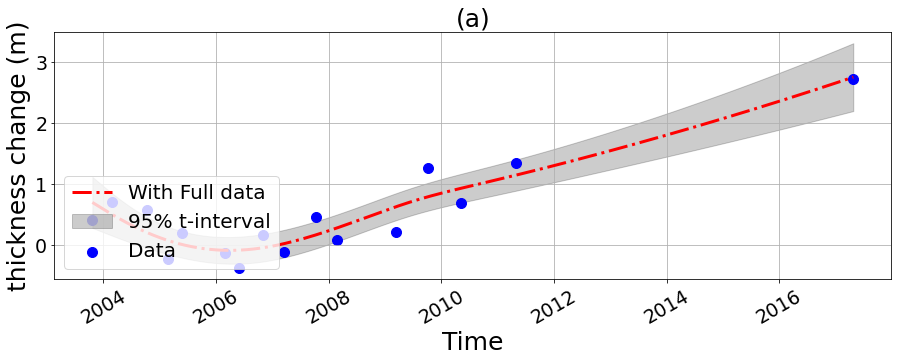

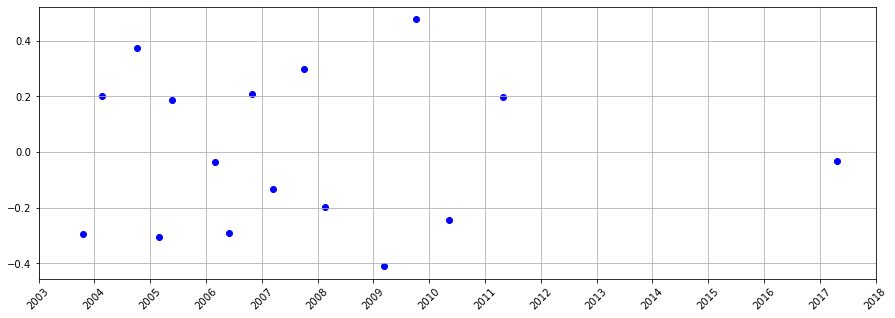

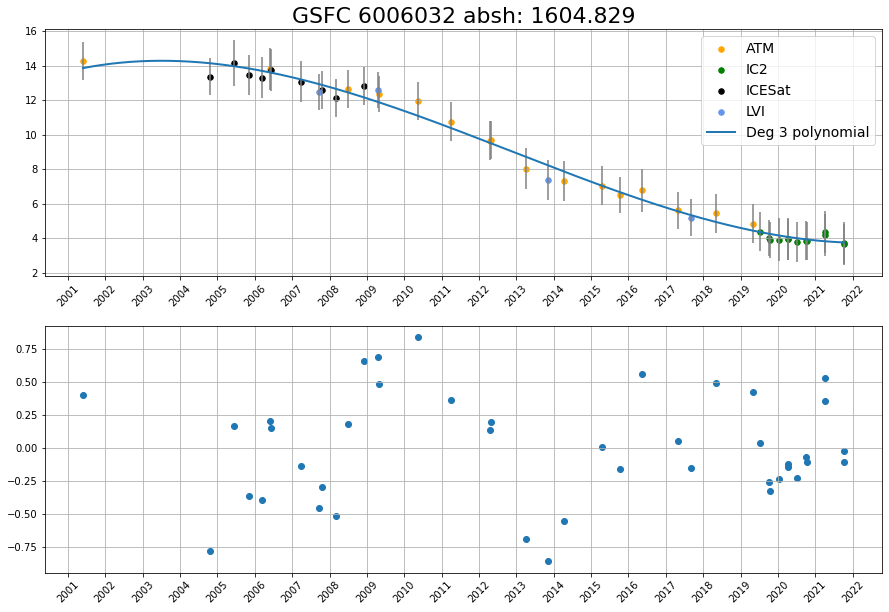

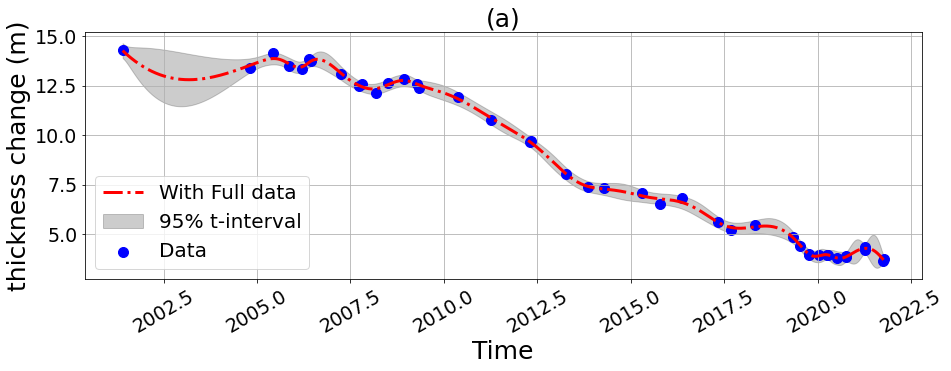

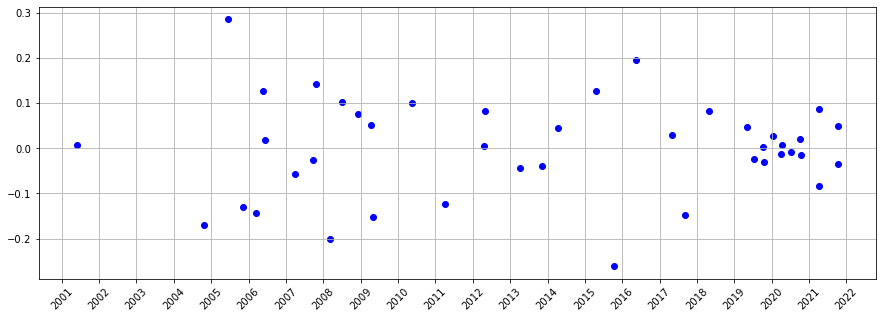

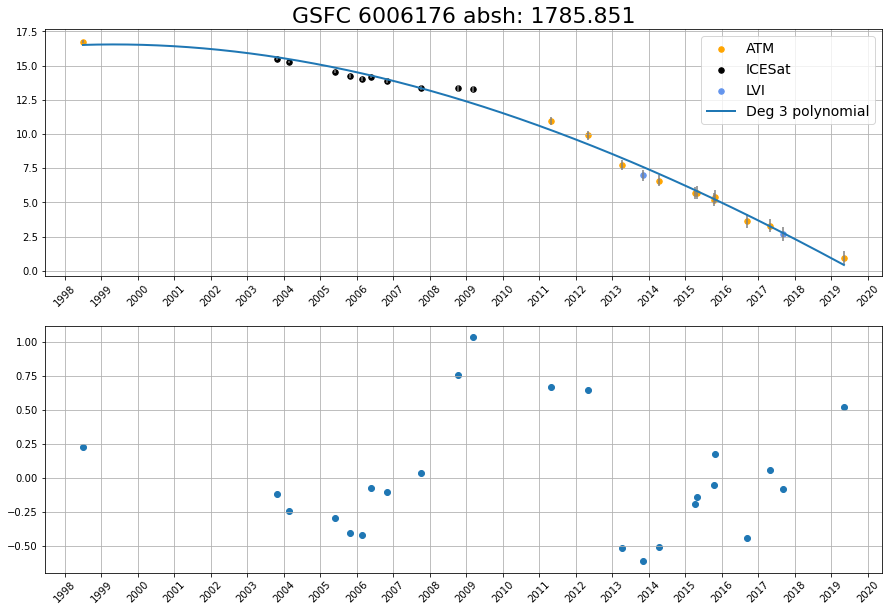

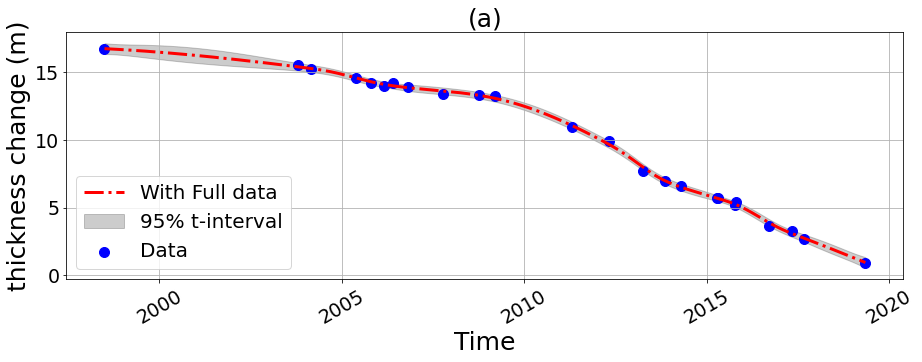

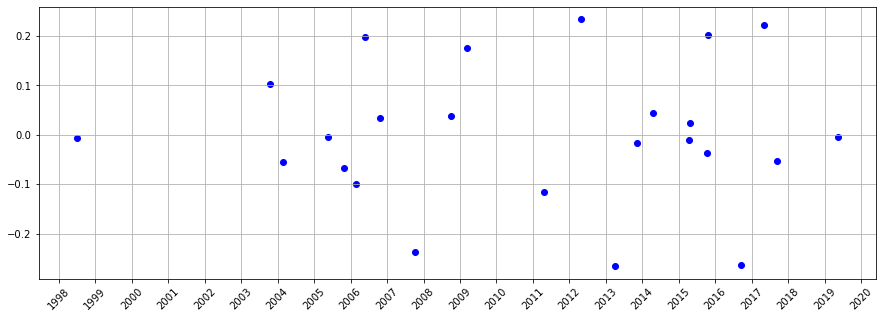

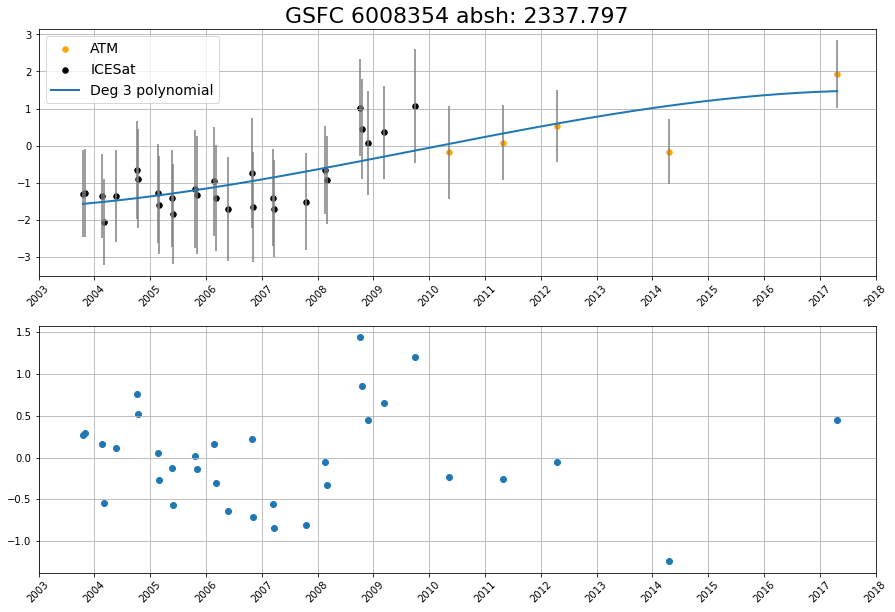

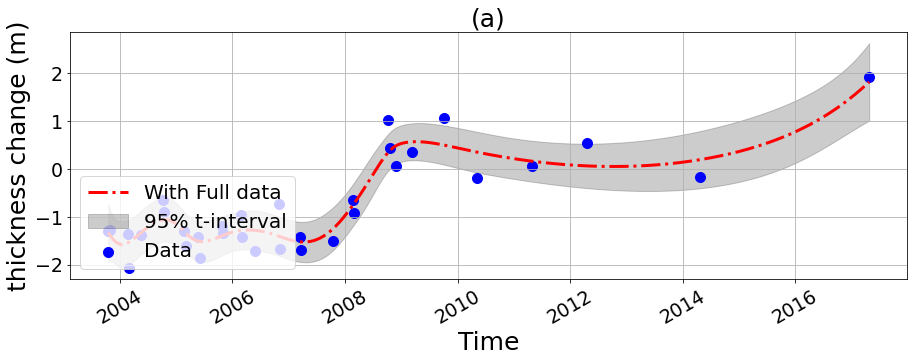

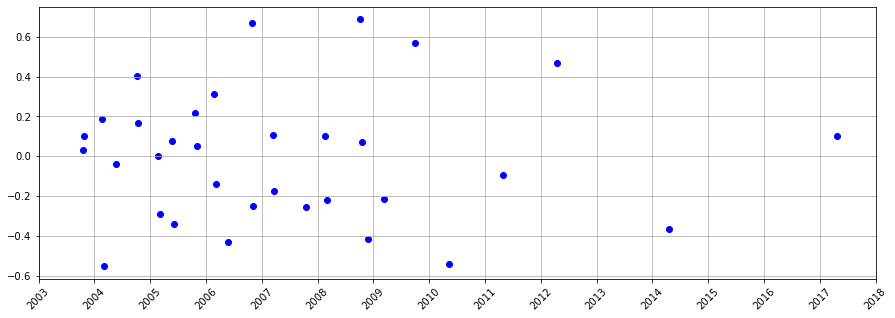

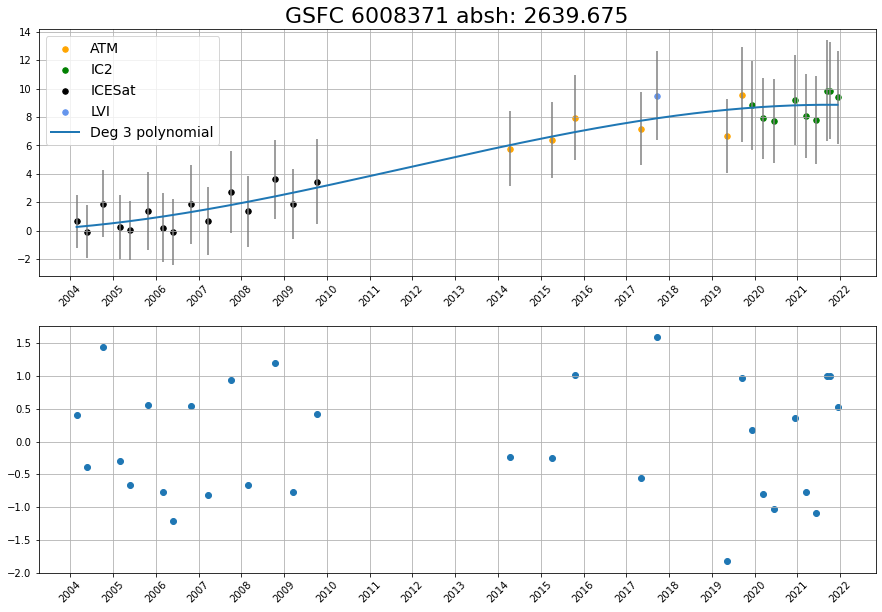

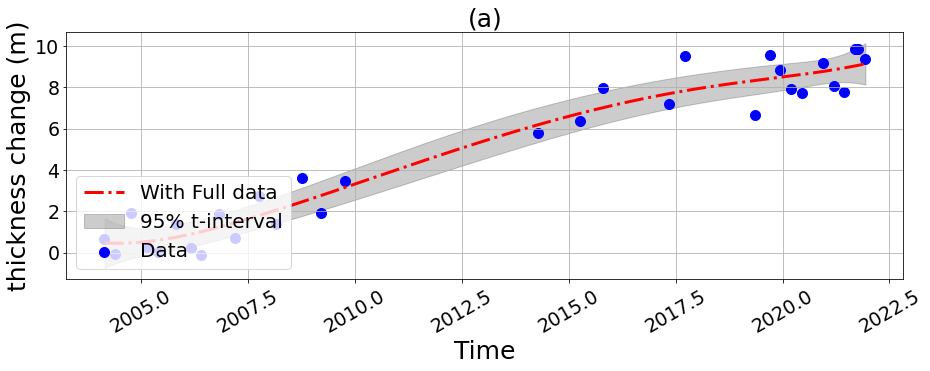

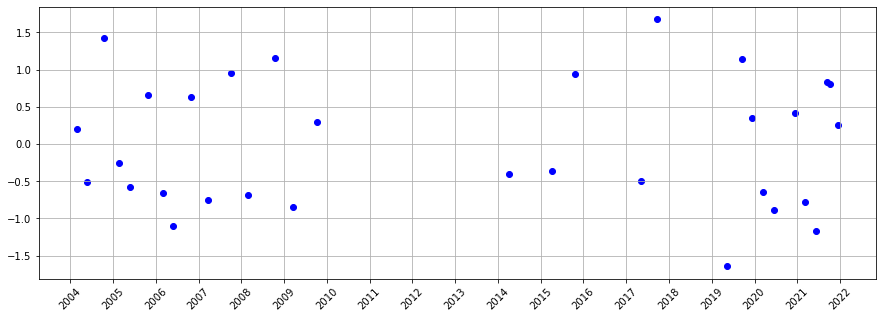

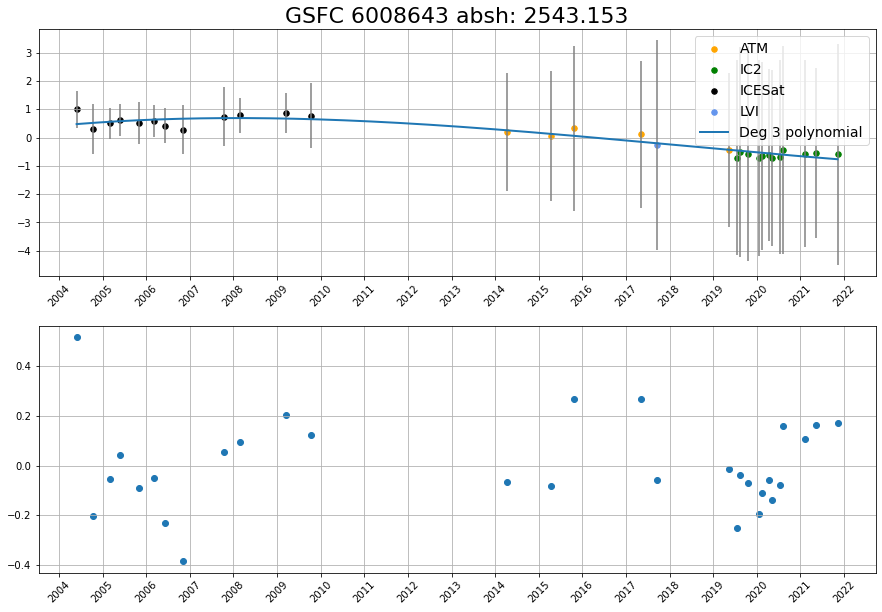

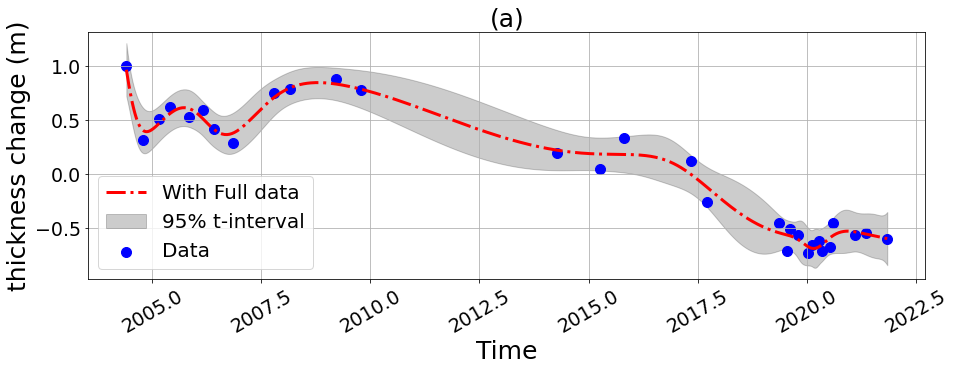

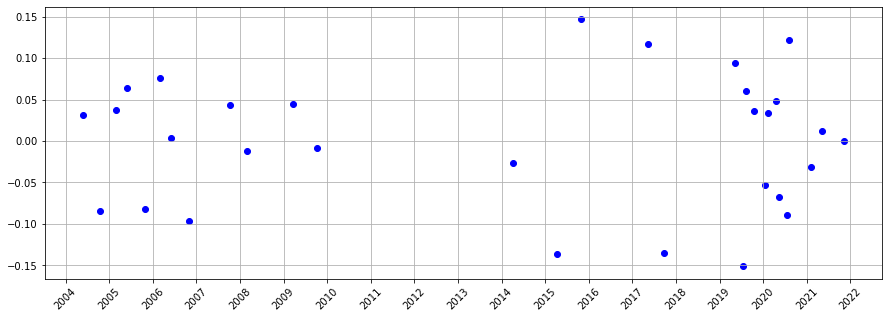

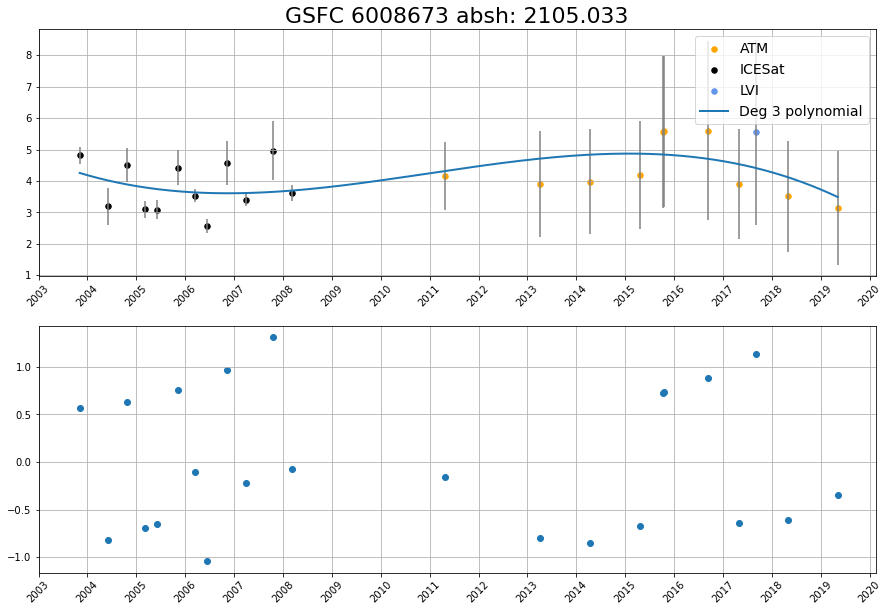

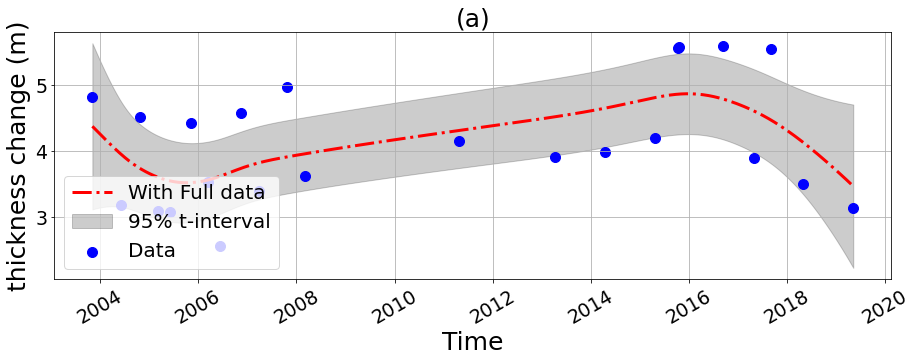

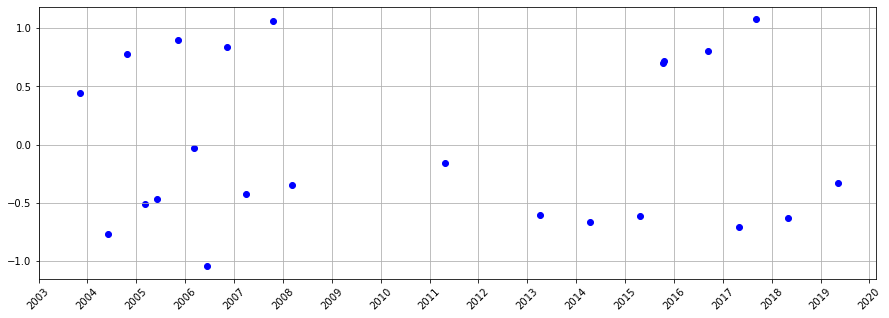

In [111]:
temp_interp(SERAC_dic_GSFC, header_GSFC, ts_index, FDM_source = "GSFC")
# temp_interp(SERAC_dic_IMAU, header_IMAU, ts_index, FDM_source = "IMAU")



In [32]:
# ## Read FDM time series

# df_fdm = pd.read_table(SERAC_dir+"FDM"+FDM_source+"_"+"Tile"+str(tile_id)+".txt", sep = "\t")
# df_fdmstd = pd.read_table(SERAC_dir+"FDMstd"+FDM_source+"_"+"Tile"+str(tile_id)+".txt", sep = "\t")


# time_fdm = np.array(df_fdm.columns[1:], dtype = float)
# df_fdmstd.head()

In [ ]:
#     ax1 = fig.add_subplot(2, 1, 1)
#     ax1.scatter(time, dyn, c = "k")
#     for d in [1, 2, 3, 4]:
#         x_pred, y_pred = poly_interp(time, dyn, deg = d)

#         d_ts = pd.Series(data=y_pred, index=np.round(x_pred, 2))
#         d_ts_dyn = d_ts.reindex(np.round(time, 2), method = 'nearest')
#         d_interp_err = pd.DataFrame({'time': time, 'err': dyn - d_ts_dyn.values})

#         SSE = np.sum(d_interp_err['err'].values**2)
#         aic = 2*(d+1)-2*np.log(SSE)
    
#         ax1.plot(x_pred, y_pred, linewidth = 2, label = "Deg "+str(d)+" polynomial interpolation, AIC = "+str(aic))
#     ax1.set_xticks(np.arange(int(x_pred[0]), int(x_pred[-1]+2), 1))
#     ax1.tick_params(axis='x', rotation=45)
#     ax1.legend(fontsize = 14)
#     ax1.set(xlabel=None, ylabel=None)
#     ax1.set_title(str(k)+"th TS "+header[0][k], fontsize = 22)



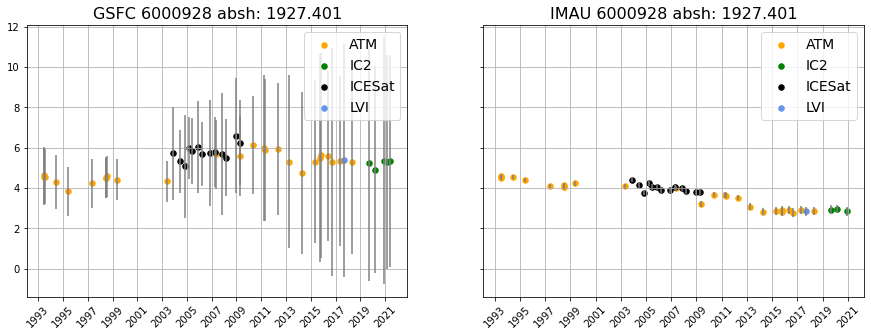

In [83]:
# ids_SERAC = ["6000928"]

# colors = {'AED':'r', 'ATM':'orange', 'LVI':'cornflowerblue', 'ICESat':'k', 'IC2':'g'}

# SERAC_dic_l = [SERAC_dic_GSFC, SERAC_dic_IMAU]
# header_l = [header_GSFC, header_IMAU]
# FDM_source_l = ["GSFC", "IMAU"]

# for id_SERAC in ids_SERAC:
    
#     fig, ax = plt.subplots(1, 2, figsize = (15,5), sharey = True)
#     for i in range(2):
#         header = header_l[i]
#         SERAC_dic = SERAC_dic_l[i]
#         FDM_source = FDM_source_l[i]
        
#         k = np.argwhere(header.iloc[:, 0].values == id_SERAC).item()

#         serac = SERAC_dic[id_SERAC]
#         serac = serac[serac[11] != -999.]
#         serac_k = serac[serac[13]==1].reset_index(drop = True)
#         serac_o = serac[serac[13]>1].reset_index(drop = True)

#         time = serac_k[1].values.astype(float)
#         dyn = serac_k[11].values.astype(float)
#         err_dyn = serac_k[12].values.astype(float)

#         for key, group in pd.DataFrame({'x':time, 'y':dyn, 'sensor':serac_k[0].values}).groupby('sensor'):
#             group.plot(ax=ax[i], kind='scatter', x='x', y='y', label=key, color=colors[key], s = 30)
#         ax[i].errorbar(time, dyn, yerr = err_dyn, color='grey', linestyle='')

#         ax[i].set_xticks(np.arange(int(time[0]), int(time[-1]+2), 2))
#         ax[i].tick_params(axis='x', rotation=45)
#         ax[i].legend(fontsize = 14)
#         ax[i].set(xlabel=None, ylabel=None)
#         ax[i].set_title(FDM_source + " " + header[0][k] + " absh: " + str(header[5][k]), fontsize = 16)


